# Predict Future Sales - Kaggle Challenge

### Problem

This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

* Prediction: how many items of a type from each shop will be sold in a whole month

### Dataset description

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

* sample_submission.csv - a sample submission file in the correct format.

* items.csv - supplemental information about the items/products.

* item_categories.csv  - supplemental information about the items categories.

* shops.csv- supplemental information about the shops.

In [133]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import image
import math
import pandas as pd
import tensorflow as tf

#sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer

# keras
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout

In [9]:
working_dir = "./" 

In [10]:
# Train dataframe
df_train = pd.read_csv(working_dir + "sales_train.csv")
n, m = df_train.shape

df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [13]:
# Test dataframe
df_test = pd.read_csv(working_dir + "test.csv")
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [21]:
# Supplemental information

df_items = pd.read_csv(working_dir + "items.csv")
print("Supplemental information about the items/products.")
print(df_items.head())

df_item_categories = pd.read_csv(working_dir + "item_categories.csv")
print("\n Supplemental information about the items categories.")
print(df_item_categories.head())

df_shops = pd.read_csv(working_dir + "shops.csv")
print("\n Supplemental information about the shops.")
print(df_shops.head())

Supplemental information about the items/products.
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  

 Supplemental information about the items categories.
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

 Supplemental information about the shops.
                        shop_name  shop_id
0   !Якутск Ор

### Exploring the dataframes

We start by verifying some information about the data, so we know how to deal with our dataframes:

In [61]:
def df_infos(df, shape=False):
    print("----------Data Types-----------")
    print(df.dtypes)
    print("\n-------Missing Values----------")
    if df.isnull().values.any() == 0:
        print("No missing values")
    else:
        print("There are missing values")
    print("\n-------NULL values-------------")
    if df.isna().values.any() == 0:
        print("No null values")
    else:
        print("There are null values")
    print("\n-----Shape Of Data-------------")
    print(df.shape)
    if shape:
        return df.shape


In [64]:
print("TRAIN")
df_infos(df_train)

TRAIN
----------Data Types-----------
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

-------Missing Values----------
No missing values

-------NULL values-------------
No null values

-----Shape Of Data-------------
(2935849, 6)


As the 'date' is the Train dataframe is an object, we will convert it into datatime format so we are able to manipulate it:

In [68]:
df_train['date'] = pd.to_datetime(df_train['date'],format = '%d.%m.%Y')
df_train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0


Verifying the test set:

In [69]:
print("\n TEST")
df_infos(df_test)


 TEST
----------Data Types-----------
ID         int64
shop_id    int64
item_id    int64
dtype: object

-------Missing Values----------
No missing values

-------NULL values-------------
No null values

-----Shape Of Data-------------
(214200, 3)


## Preparing for NN

We start by analising how many times each item was counted in each shop in a month. That way, we have that the counts for months 0-32 will be the data used as X, while the month 33 will be used as the labels to our prediction.

We will start by creating a pivot table:

In [111]:
dataset = df_train.pivot_table(index = ['shop_id','item_id'],
                               values = ['item_cnt_day'],
                               columns = ['date_block_num'],
                               fill_value = 0,
                               aggfunc='sum')

In [112]:
dataset.reset_index(inplace = True)
dataset.head(5)

shop_id item_id item_cnt_day                        ...        \
date_block_num                            0   1  2  3  4  5  6  7  ... 24 25   
0                    0      30            0  31  0  0  0  0  0  0  ...  0  0   
1                    0      31            0  11  0  0  0  0  0  0  ...  0  0   
2                    0      32            6  10  0  0  0  0  0  0  ...  0  0   
3                    0      33            3   3  0  0  0  0  0  0  ...  0  0   
4                    0      35            1  14  0  0  0  0  0  0  ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  
2               0  0  0  0  0  0  0  0  
3               0  0  0  0  0  0  0  0  
4               0  0  0  0  0  0  0  0  

[5 rows x 36 columns]

In [113]:
dataset = pd.merge(df_test, dataset,on = ['item_id','shop_id'], how = 'left')
dataset.fillna(0,inplace = True)

dataset.head(10)

/tmp/ipykernel_64122/3382234583.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  dataset = pd.merge(df_test, dataset,on = ['item_id','shop_id'], how = 'left')
/home/marina/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,5,5039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0
6,6,5,5041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
7,7,5,5046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,8,5,5319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,2.0,3.0,2.0,2.0,4.0,3.0,2.0,3.0,0.0
9,9,5,5003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
dataset.drop(['ID', 'shop_id','item_id'],inplace = True, axis = 1)

As already stated, the X will then be all the columns exepct the last one, which will be our y (the labels that we cant to predict).

In [119]:
# X we will keep all columns execpt the last one 
X_train = np.expand_dims(dataset.values[:,:-1],axis = 2)
y_train = dataset.values[:,-1:]

In [124]:
# For test we keep all the columns execpt the first one
X_test = np.expand_dims(dataset.values[:,1:],axis = 2)

### MLP approach

With all the data in our hands, we can finally create and train our model:

In [135]:
adam = tf.keras.optimizers.Adam(learning_rate)

model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dropout(0.4))
model_mlp.add(Dense(1))

model_mlp.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               3400      
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,501
Trainable params: 3,501
Non-trainable params: 0
_________________________________________________________________


In [136]:
model_mlp.compile(loss='mse', optimizer=adam, metrics = ['mean_squared_error'])

In [137]:
history_mlp = model_mlp.fit(X_train,y_train,batch_size = 4096,epochs = 10)

Epoch 1/10
53/53 [==============================] - 0s 3ms/step - loss: 32.1833 - mean_squared_error: 32.1833
Epoch 2/10
53/53 [==============================] - 0s 3ms/step - loss: 26.1093 - mean_squared_error: 26.1093
Epoch 3/10
53/53 [==============================] - 0s 4ms/step - loss: 27.9914 - mean_squared_error: 27.9914
Epoch 4/10
53/53 [==============================] - 0s 4ms/step - loss: 24.6949 - mean_squared_error: 24.6949
Epoch 5/10
53/53 [==============================] - 0s 4ms/step - loss: 22.1824 - mean_squared_error: 22.1824
Epoch 6/10
53/53 [==============================] - 0s 3ms/step - loss: 21.7592 - mean_squared_error: 21.7592
Epoch 7/10
53/53 [==============================] - 0s 3ms/step - loss: 20.8854 - mean_squared_error: 20.8854
Epoch 8/10
53/53 [==============================] - 0s 3ms/step - loss: 21.6180 - mean_squared_error: 21.6180
Epoch 9/10
53/53 [==============================] - 0s 3ms/step - loss: 19.3571 - mean_squared_error: 19.3571
Epoch 10/1

That step being compleated, we can then analyse the evolution of our loss in the training dataset:

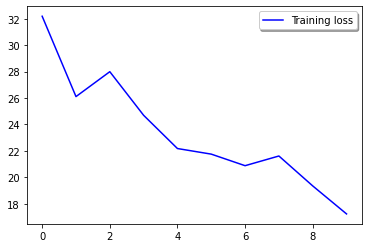

In [138]:
plt.plot(history_mlp.history['loss'], color='b', label="Training loss")
plt.legend(loc='best', shadow=True)

### RNN/LSTM approach

In [126]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape = (X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(1))

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [127]:
model_lstm.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])

In [128]:
history_lstm = model_lstm.fit(X_train,y_train,batch_size = 4096,epochs = 10)

Epoch 1/10
53/53 [==============================] - 13s 236ms/step - loss: 30.6105 - mean_squared_error: 30.6105
Epoch 2/10
53/53 [==============================] - 13s 246ms/step - loss: 30.3613 - mean_squared_error: 30.3613
Epoch 3/10
53/53 [==============================] - 14s 267ms/step - loss: 30.0623 - mean_squared_error: 30.0623
Epoch 4/10
53/53 [==============================] - 14s 271ms/step - loss: 30.0163 - mean_squared_error: 30.0163
Epoch 5/10
53/53 [==============================] - 14s 263ms/step - loss: 29.8564 - mean_squared_error: 29.8564
Epoch 6/10
53/53 [==============================] - 15s 275ms/step - loss: 29.7857 - mean_squared_error: 29.7857
Epoch 7/10
53/53 [==============================] - 13s 252ms/step - loss: 29.7232 - mean_squared_error: 29.7232
Epoch 8/10
53/53 [==============================] - 15s 279ms/step - loss: 29.7237 - mean_squared_error: 29.7237
Epoch 9/10
53/53 [==============================] - 14s 268ms/step - loss: 29.5939 - mean_square

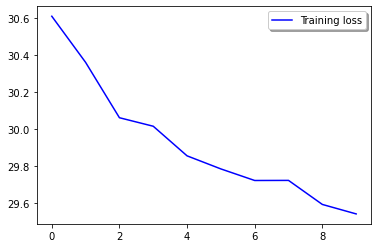

In [130]:
plt.plot(history_lstm.history['loss'], color='b', label="Training loss")
plt.legend(loc='best', shadow=True)

### CNN approach

In [141]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))

model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 32, 64)            192       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 16, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 50)                51250     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 51,493
Trainable params: 51,493
Non-trainable params: 0
__________________________________________________

In [142]:
model_cnn.compile(loss='mse', optimizer=adam)

In [145]:
cnn_history = model_cnn.fit(X_train, y_train, epochs=10, verbose=2)

Epoch 1/10
6694/6694 - 6s - loss: 24.2476 - 6s/epoch - 948us/step
Epoch 2/10
6694/6694 - 6s - loss: 25.1013 - 6s/epoch - 941us/step
Epoch 3/10
6694/6694 - 7s - loss: 23.5931 - 7s/epoch - 1ms/step
Epoch 4/10
6694/6694 - 7s - loss: 25.0661 - 7s/epoch - 1ms/step
Epoch 5/10
6694/6694 - 7s - loss: 20.4200 - 7s/epoch - 1ms/step
Epoch 6/10
6694/6694 - 8s - loss: 19.4496 - 8s/epoch - 1ms/step
Epoch 7/10
6694/6694 - 9s - loss: 28.7757 - 9s/epoch - 1ms/step
Epoch 8/10
6694/6694 - 8s - loss: 18.4452 - 8s/epoch - 1ms/step
Epoch 9/10
6694/6694 - 8s - loss: 24.4035 - 8s/epoch - 1ms/step
Epoch 10/10
6694/6694 - 7s - loss: 22.2765 - 7s/epoch - 1ms/step


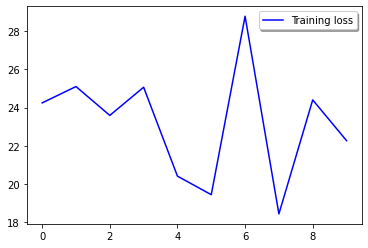

In [146]:
plt.plot(cnn_history.history['loss'], color='b', label="Training loss")
plt.legend(loc='best', shadow=True)

In [ ]:
### 

## Submission file